5.4.1 곱셈 계층

In [1]:
# 곱셈 계층
class MulLayer:
    # 역전파 시 입력값이 필요하므로 x,y를 저장해야함 
    def __init__(self):
        self.x = None
        self.y = None

    # 순전파 과정에서 입력값 저장 
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x*y

        return out

    # 두 입력값을 바꿔서 곱하기 
    def backward(self, dout):  # dout: 상류에서 넘어온 미분값 (differential output)
        dx = dout * self.y
        dy = dout * self.x 

        return dx, dy

In [2]:
# ex1을 구현 
apple = 100
apple_num = 2
tax = 1.1

# layers
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward propagation
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print("apple price:", apple_price)
print("price:", price)

apple price: 200
price: 220.00000000000003


In [3]:
# 역전파 
dprice = 1
# backward() 가 받는 인수는 순전파의 출력에 대한 미분! 
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


5.4.2 덧셈 계층

In [4]:
# 덧셈 계층 
class AddLayer:
    # 덧셈 계층은 입력값을 쓰지 않으므로 초기화가 필요 없음 
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out

    # 그대로 흘려보냄 
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        # return dout, dout 과 같음 
        return dx, dy

In [5]:
# ex2 를 구현

apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layers
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward propagation
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

print("apple price:",apple_price)
print("orange_price:", orange_price)
print("all price:", all_price)
print("price:", price)



apple price: 200
orange_price: 450
all price: 650
price: 715.0000000000001


In [6]:
# backpropagation
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple_num, dapple, dorange, dorange_num, dtax)

110.00000000000001 2.2 3.3000000000000003 165.0 650


5.5.1 ReLU 계층

In [7]:
import numpy as np
import copy

In [8]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        # 0 이하인 위치를 기억해 두었다가(True)
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        # 그 위치에 역전파를 할 때 0으로 바꿔준다
        dout[self.mask] = 0
        dx = dout

        return dx

In [9]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print("x is\n",x)
mask = (x<=0)
print("after mask\n",mask)


x is
 [[ 1.  -0.5]
 [-2.   3. ]]
after mask
 [[False  True]
 [ True False]]


5.5.2 Sigmoid 계층

In [10]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * (1 - self.out)* self.out

        return dx 
        

5.6.2 배치용 Affine 계층

In [11]:
X_dot_W = np.array([[0,0,0],[10,10,10]])
B = np.array([1,2,3])

print(X_dot_W + B)
# B가 행마다 더해지는 것을 알 수 있음 

[[ 1  2  3]
 [11 12 13]]


In [12]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.dW = None

    # Y = XW + B
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    # dx = (미분값) @ W^T 
    # dW = X^T @ (미분값)
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

5.6.3 Softmax-with-Loss 계층

In [13]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self,x,t):
        self.t = t
        self.y = softmax(x)
        # softmax와 one-hot encoding으로 된 t의 cross entropy error 계산 
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    # dout=1 은 왜 필요하지? 
    def backward(self, dout=1):
        # batch 라고 가정하고 계산 
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size 

        return dx 

5.7.2 오차역전파법을 적용한 신경망 구현하기 

In [15]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


In [18]:
# 계층을 모듈화해서 구현 -> 깊은 신경망도 쉽게 구현 가
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, \
        weight_init_std=0.01):

        # 가중치들을 담는 매개변수 
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)


        # layer들은 순서가 있음 
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        # 신경망의 마지막 계층 
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y,t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)

        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x,t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        self.loss(x,t)

        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        # 역전파를 하기 위해 layer들을 뒤집자 
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

    

5.7.3 오차역전파법으로 구한 기울기 검증하기

In [19]:
# 수치미분법은 느리지만 구현이 쉬움
# 따라서 두 방식으로 구한 기울기가 거의 같음을 보여서
# 오차역전파법을 잘 구현했는지 확인하자
# := 기울기 확인(gradient check)이라고 함 


In [20]:
import sys, os 
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet


In [21]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 다 하는 건 오래걸리므로 테스트 용으로 몇 개의 데이터만 이용 
x_batch = x_train[:3]
t_batch = t_train[:3]

# 수치 미분과 오차역전파법으로 기울기를 구한다
grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 층 별로 가중치 차이의 절댓값을 구하고, 평균을 낸다. 
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

# 결과가 0에 매우 근접하므로 오차역전파법이 잘 구현됐을 가능성이 매우 높다.


W1:3.4034943952064465e-10
b1:2.178495673450234e-09
W2:5.925262837012661e-09
b2:1.4034987535632705e-07


5.7.4 오차역전파법을 사용한 학습 구현하기

In [23]:
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 0이 되면 나눌 때 에러가 발생할 수 있으므로 
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 오차역전파법으로 gradient 계산 
    grad = network.gradient(x_batch, t_batch)

    # 구한 gradient로 parameter 갱신 
    for key in grad.keys():
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # epoch 마다 학습 경과 확인 
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.11036666666666667 0.1094
0.9049166666666667 0.9072
0.9268833333333333 0.9281
0.9355 0.9339
0.9455333333333333 0.9425
0.9524666666666667 0.9502
0.9571166666666666 0.9523
0.9612333333333334 0.9568
0.9650666666666666 0.9606
0.9666333333333333 0.962
0.9706166666666667 0.9657
0.9708166666666667 0.9655
0.9734 0.9674
0.9747666666666667 0.9685
0.97515 0.9675
0.9780166666666666 0.971
0.9789833333333333 0.9708


In [24]:
import matplotlib.pyplot as plt


In [26]:
len(train_acc_list)

17

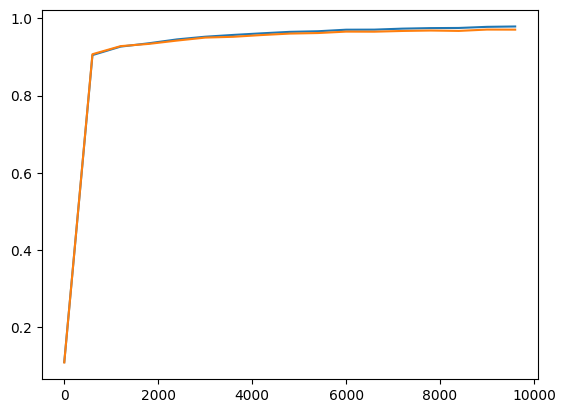

In [31]:

x = np.arange(len(train_acc_list)) * iter_per_epoch
plt.plot(x, train_acc_list)
plt.plot(x, test_acc_list)
plt.show()

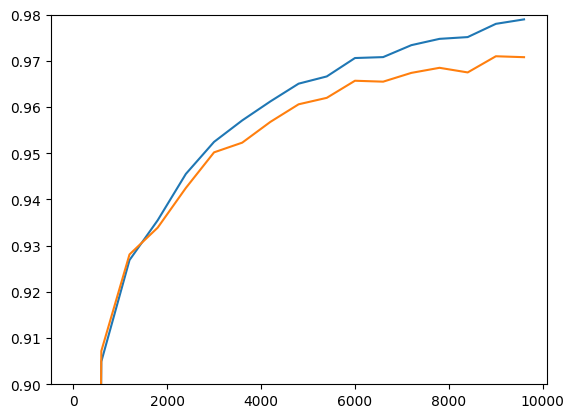

In [34]:
plt.ylim(0.9,0.98)
plt.plot(x, train_acc_list)
plt.plot(x, test_acc_list)
plt.show()
# test와 train의 정확도가 매우 비슷한 것으로 보아
# 오버피팅이 없거나 거의 적음을 알 수 있다!

In [ ]:


plt.plot(x, y)
plt.show()